In [14]:
#!pip install numpy
#!pip install prettytable
#!pip install scikit-learn

In [15]:
import random
from abc import ABC, abstractmethod

import numpy as np

from sklearn.datasets import fetch_openml

import os

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
class Dataset:
    def __shift_image(self,image, direction):
        img_2d = image.reshape(28, 28)
        shifted = np.zeros_like(img_2d)
        
        if direction == 'left':
            shifted[:, :-1] = img_2d[:, 1:]
        elif direction == 'right':
            shifted[:, 1:] = img_2d[:, :-1]
        elif direction == 'up':
            shifted[:-1, :] = img_2d[1:, :]
        elif direction == 'down':
            shifted[1:, :] = img_2d[:-1, :]
    
        return shifted.reshape(784)
    
    def load_data_openml(self,title,version):
        dataset = fetch_openml(title, version=version, as_frame=False)
        self.dataset_images = dataset["data"].astype('float32') / 255
        self.dataset_labels = dataset["target"].reshape(-1, 1).astype('int32')
    def augmentation(self):
        
        directions = ['left', 'right', 'up', 'down']
        n_samples = self.dataset_images.shape[0]
    
        # Создаем массивы для расширенного набора (оригинал + 4 сдвинутых версии)
        x_augmented = np.zeros((n_samples * 5, 784))
        y_augmented = np.zeros((n_samples * 5, 1))
    
        for i in range(n_samples):
            # Добавляем оригинальное изображение
            x_augmented[i * 5] = self.dataset_images[i]
            y_augmented[i * 5] = self.dataset_labels[i]
    
            # Добавляем сдвинутые версии
            for j, direction in enumerate(directions):
                x_augmented[i * 5 + j + 1] = self.__shift_image(self.dataset_images[i], direction)
                y_augmented[i * 5 + j + 1] = self.dataset_labels[i]
        
        print(f"Размер оригинального набора данных: {self.dataset_images.shape[0]} изображений")
        print(f"Размер расширенного набора данных: {x_augmented.shape[0]} изображений")
        print(f"Коэффициент увеличения: {x_augmented.shape[0] / self.dataset_images.shape[0]:.1f}x")
        self.dataset_images = x_augmented
        self.dataset_labels = y_augmented
    
    def __call__(self, *args, **kwargs):
        
        return self.dataset_images, self.dataset_labels

In [17]:
class Activation:
    @staticmethod
    def SIGMOID():
        def activation(x):
            return 1 / (1 + np.exp(-x))
        def derivative(x):
            return x * (1 - x)
        return activation, derivative
    
    @staticmethod
    def TANH():
        def activation(x):
            return np.tanh(x)
        def derivative(x):
            return 1 - x ** 2
        return activation, derivative


In [18]:
class Layer:
    def __init__(self, input_size, output_size, activation_func):
        self.activate, self.derivative = activation_func()
        self.weights = np.random.uniform(-0.5,0.5,size=(input_size, output_size))
        self.biases = np.zeros(output_size)        
    def __call__(self):
        return {
            'weights':self.weights, 
            'biases':self.biases
                }

In [19]:
class NN(ABC):
    def __init__(self, layers):
        self.layers = layers
        self.params = self.__params()
    
    def __params(self):
        params = {}
        for i, layer in enumerate(layers):
            params[f'layer{i}'] = {"weights":layer.weights,
                                   "biases":layer.biases}
        return params
    def _forward(self, x):
        for layer in self.layers:
            z = np.dot(x, layer.weights) + layer.biases
            x = layer.activate(z)
            layer.output = np.array([x])
        return x
    
    def _backward(self, x, y, lr):
        error = -(y - self.layers[-1].output)
        for layer in reversed(self.layers):
            delta = error * layer.derivative(layer.output)
            prev_output = np.array([x]) if layer == self.layers[0] else self.layers[self.layers.index(layer) - 1].output
            
            layer.weights -= lr * np.dot(prev_output.T, delta)
            layer.biases -= lr * np.sum(delta, axis=0)
            error = np.dot(delta, layer.weights.T)
        
    @abstractmethod
    def train(self):
        pass
    
    
    
    def __call__(self, input_data):
        output = []
        for i in range(input_data.shape[0]):
            output.append(self._forward(input_data[i]))
        return  output
    

In [262]:
class MnistNN(NN):
    def __init__(self, layers):
        super().__init__(layers)
        
    def __MSE(self, output, p_out):
        error = 1/10 * np.sum((output - p_out)**2, axis = 0) #MSE
        return error
    
    def train(self, images, labels, epochs, learning_rate=0.01):
        self.epochs = epochs
        self.chart_y_train = []
        self.chart_y_test = []
        index_list = list(range(210000))
        for i in range(epochs):
            random.shuffle(index_list)
            train_loss, train_correct, test_loss, test_correct = 0.0, 0, 0.0, 0
            p_bar = tqdm(index_list, total=210000)
            p_bar.set_description(f"Epoch {i+1}/{epochs} Status:train")
            for j in p_bar: 
                
                p_out = self._forward(images[j])
                
                train_loss += np.sum(self.__MSE(labels[j],p_out))
                train_correct += int(labels[j].argmax() == p_out.argmax())
                
                self._backward(images[j], labels[j], learning_rate)
                
            p_bar = tqdm(zip(images[210000:350000], labels[210000:350000]), total = 140000)
            p_bar.set_description(f"Epoch {i+1}/{epochs} Status:test")
            for image, label in p_bar:
                p_out = self._forward(image)
                test_loss += np.sum(self.__MSE(label,p_out))
                test_correct += int(label.argmax() == p_out.argmax())
            
            self.chart_y_train.append(1.0-train_correct/210000)
            self.chart_y_test.append(1.0-test_correct/140000)
            print(f"Epoch {i+1}/{epochs}\n"
                  f"Loss: {round((train_loss/210000.0) * 100, 2)}%, Correct: {round((train_correct/210000.0) * 100, 2)}%\n"
                  f"Test_loss: {round((test_loss/140000.0) * 100, 2)}%, Correct: {round((test_correct/140000.0) * 100, 2)}%")
            
    
    def plot_learning(self):
        epochs = [i for i in range(self.epochs)]
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.chart_y_train, 'r-', label='ошибка обучения')
        plt.plot(epochs, self.chart_y_test, 'b-', label='ошибка тестирования')
        plt.axis([0, len(epochs), 0.0, 1.0])
        plt.xlabel('эпохи обучения')
        plt.ylabel('ошибка')
        plt.legend()
        plt.grid(True)
        plt.show()


In [263]:
dataset = Dataset()
dataset.load_data_openml("mnist_784", 1)

In [264]:
dataset.augmentation()

Размер оригинального набора данных: 70000 изображений
Размер расширенного набора данных: 350000 изображений
Коэффициент увеличения: 5.0x


In [265]:
train_images, train_labels = dataset()

In [266]:
train_labels = train_labels.astype('int32')

In [267]:
train_labels

array([[5],
       [5],
       [5],
       ...,
       [6],
       [6],
       [6]])

In [268]:
train_labels = np.eye(10)[train_labels]

In [275]:
train_labels[0]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [270]:
#~~Структура нейросети~~#
layers = (
    Layer(784, 128, Activation.TANH),
    Layer(128,64,Activation.TANH),
    Layer(64, 10, Activation.SIGMOID),
)

In [271]:
model = MnistNN(layers) #создание объекта нейросети
print(model.params['layer0']['weights']) #вывод параметров

[[ 0.12732079  0.2057161  -0.12674535 ...  0.14466188  0.30257168
   0.11232429]
 [ 0.39927915 -0.25146042  0.08183082 ...  0.17135011  0.32721728
  -0.45864167]
 [-0.43747829 -0.39808261 -0.07574516 ... -0.23089477 -0.14990315
   0.06245454]
 ...
 [-0.37989209  0.19611934 -0.29243357 ...  0.09717416 -0.43013475
  -0.2676285 ]
 [-0.26716188  0.41998106  0.05428111 ...  0.25447031  0.23918266
   0.28243951]
 [ 0.10964908  0.31983331  0.46663107 ...  0.44021102  0.32878299
  -0.36884777]]


In [272]:
LEARNING_RATE = 0.01
EPOCH = 10

In [273]:
#~~Обучение нейросети~~#
model.train(train_images,train_labels, EPOCH, learning_rate=LEARNING_RATE) 

Epoch 1/10 Status:test: 100%|██████████| 140000/140000 [00:21<00:00, 6410.38it/s]


Epoch 1/10
Loss: 2.07%, Correct: 86.95%
Test_loss: 1.19%, Correct: 92.8%


Epoch 2/10 Status:test: 100%|██████████| 140000/140000 [00:21<00:00, 6521.16it/s]


Epoch 2/10
Loss: 1.0%, Correct: 93.95%
Test_loss: 0.91%, Correct: 94.47%


Epoch 3/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 14805.84it/s]


Epoch 3/10
Loss: 0.76%, Correct: 95.42%
Test_loss: 0.78%, Correct: 95.23%


Epoch 4/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 14668.69it/s]


Epoch 4/10
Loss: 0.64%, Correct: 96.26%
Test_loss: 0.7%, Correct: 95.71%


Epoch 5/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 14312.43it/s]


Epoch 5/10
Loss: 0.55%, Correct: 96.82%
Test_loss: 0.66%, Correct: 95.94%


Epoch 6/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 15046.88it/s]


Epoch 6/10
Loss: 0.49%, Correct: 97.16%
Test_loss: 0.63%, Correct: 96.15%


Epoch 7/10 Status:test: 100%|██████████| 140000/140000 [00:10<00:00, 13935.96it/s]


Epoch 7/10
Loss: 0.44%, Correct: 97.49%
Test_loss: 0.6%, Correct: 96.29%


Epoch 8/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 14932.33it/s]


Epoch 8/10
Loss: 0.4%, Correct: 97.75%
Test_loss: 0.58%, Correct: 96.48%


Epoch 9/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 15064.20it/s]


Epoch 9/10
Loss: 0.36%, Correct: 97.95%
Test_loss: 0.58%, Correct: 96.51%


Epoch 10/10 Status:test: 100%|██████████| 140000/140000 [00:09<00:00, 15277.60it/s]

Epoch 10/10
Loss: 0.33%, Correct: 98.12%
Test_loss: 0.55%, Correct: 96.63%


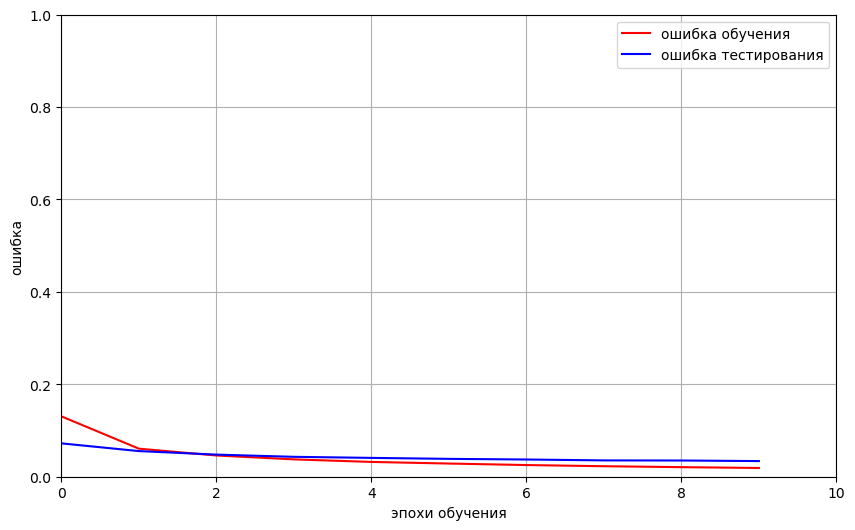

In [274]:
model.plot_learning()

In [115]:
def RGB2URGB(img):
    gray = lambda rgb: np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
    return (1 - (gray(img).astype("float32") / 255))

In [116]:
PATH = "C:/Users/madro/Documents/GitHub/Khokhlov_Dimitrii_20121_23/AI/P.6/data/test/"

In [117]:
def show(images, labels):
    for img, label in zip(images, labels):
        plt.imshow(np.array([img]).reshape(28,28), cmap = 'grey')
        predict = model(np.array([img]))[0].argmax()
        color = "red" if predict != label[0]  else "blue"
        plt.title(f"Real:{label[0]} Predicted:{predict}", color=color)
        plt.show()

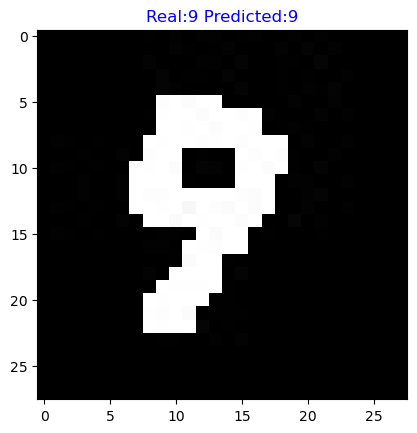

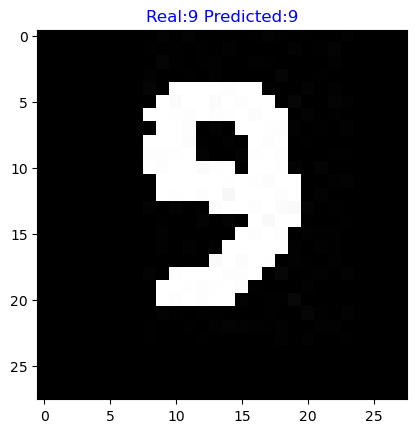

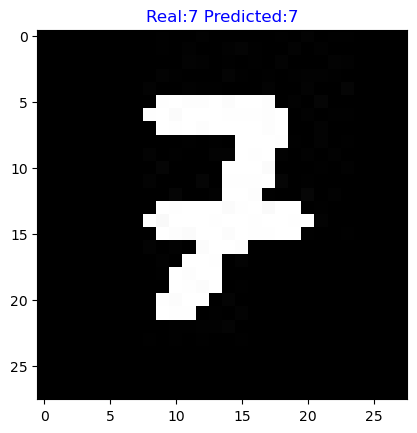

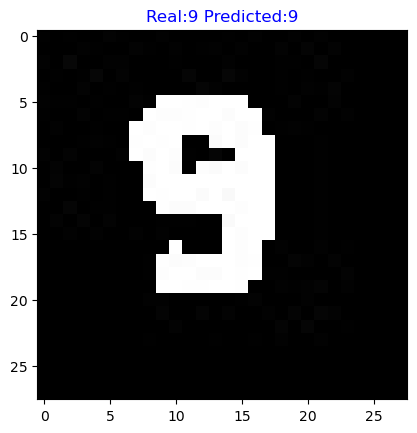

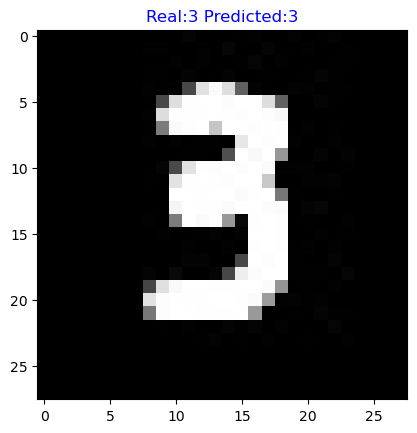

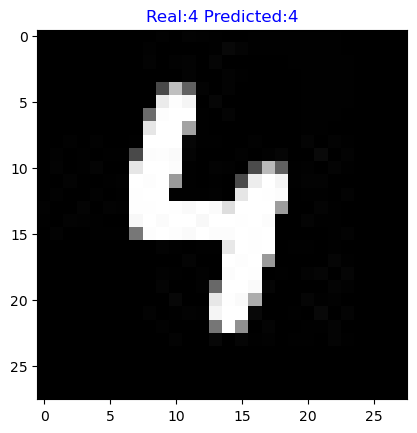

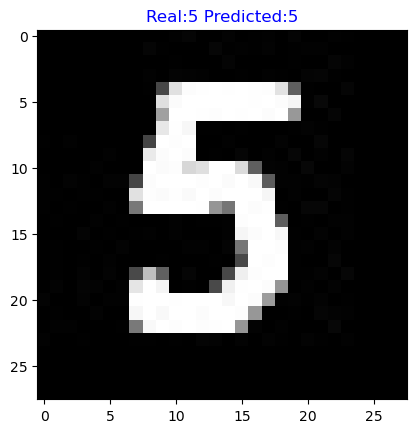

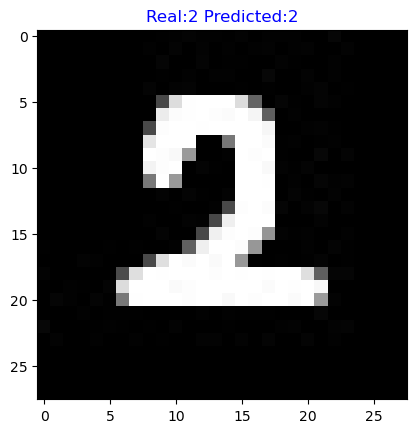

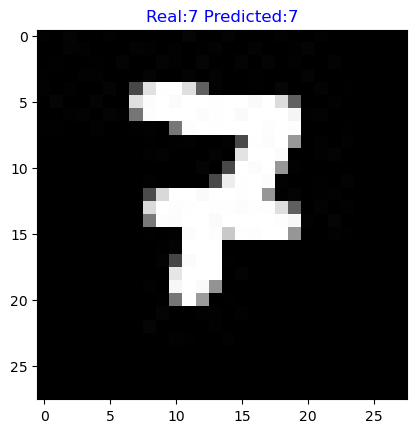

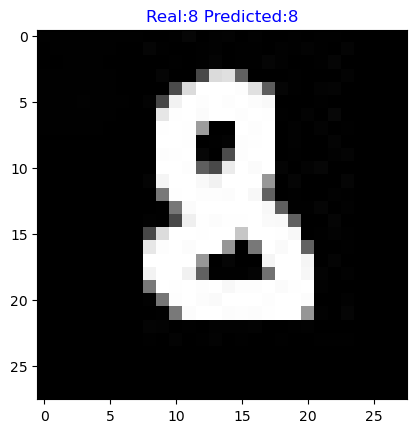

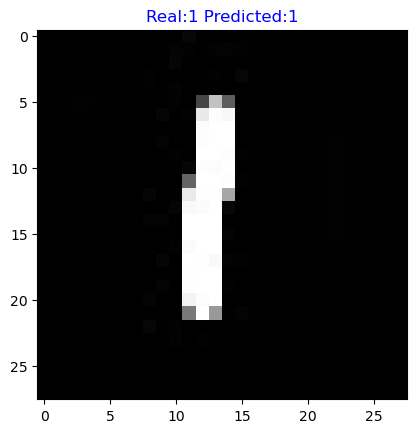

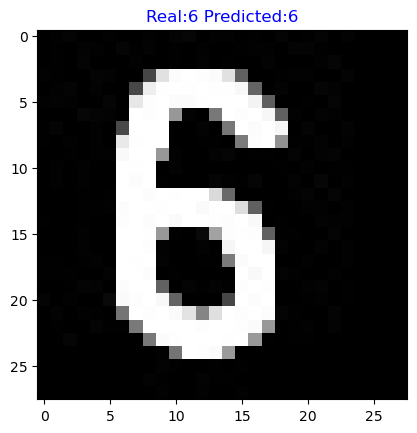

In [123]:
images=[]
for i in range(1, len(os.listdir(PATH)) + 1):
    img = plt.imread(f"{PATH}test{i}.jpg",format = "jpeg")
    images.append(RGB2URGB(img).reshape(784))
labels = np.array([9,9,7,9,3,4,5,2,7,8,1,6]).reshape(-1,1)
show(images, labels)